In [1]:
import h5py
import numpy as np
import torch
from ResNet import resnet50,resnet152,resnet18,resnet101
from mixer import MLPMixer
with h5py.File('/home/zsc/ADS_B_select_files_/dataset/noise_64x64_202004xx_to_202011xx.h5','r') as f:
    X_train = np.array(f['X_train'][:])
    y_train = np.array(f['y_train'][:])
    X_test = np.array(f['X_test'][:])
    y_test = np.array(f['y_test'][:])
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

15072 15072
14395 14395


In [2]:
from DataSet import DataSet64x64,DataLoader,DataSet16x16
train_data = DataSet64x64(X_train, y_train)
test_data = DataSet64x64(X_test, y_test)

train_loader = DataLoader(train_data,batch_size=32,shuffle=True,num_workers=4)
test_loader = DataLoader(test_data,batch_size=32,shuffle=True,num_workers=4)

In [3]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
lr = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)
# model = MLPMixer(
#     image_size = 64,
#     patch_size = 16,
#     channels=1,
#     dim = 512,
#     depth = 2,
#     num_classes = 34
# ).to(device)
model = resnet50(1,34).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)
save_path = './model/cross__noise_202004xx_202011xx_ResNet50.pth'
best_acc_train = 0
best_acc_test = 0
for epoch in range(15):
    model.train()
    running_loss = 0
    for i, (x,y) in enumerate(train_loader):
        X , Y = x.to(device),y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs,Y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print('Epoch {},  [ {} / {} ] , RunningLoss: {:.4f}'.format(epoch+1,i+1,len(train_loader),running_loss/100))
            running_loss = 0
    
    if (epoch+1) % 5 == 0:
            lr /= 2
            update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for x,y in test_loader:
            x,y = x.to(device),y.to(device)
            outputs = model(x)
            _ , predicted = torch.max(outputs.data,1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        Tcorrect = 0
        Ttotal = 0
        for x,y in train_loader:
            x,y = x.to(device),y.to(device)
            outputs = model(x)
            _ , predicted = torch.max(outputs.data,1)
            Ttotal += y.size(0)
            Tcorrect += (predicted == y).sum().item()
        print('Epoch {}, acc (TestSet): {:.4f}%, acc (TrainSet) : {:.4f}%'.format(epoch+1,correct/total*100,Tcorrect/Ttotal*100))

    if best_acc_train + best_acc_test <= Tcorrect/Ttotal + correct/total:
        # torch.save(model.state_dict(),save_path)
        best_acc_test = Tcorrect/Ttotal
        best_acc_train = correct/total



Epoch 1,  [ 100 / 471 ] , RunningLoss: 2.9638
Epoch 1,  [ 200 / 471 ] , RunningLoss: 2.2320
Epoch 1,  [ 300 / 471 ] , RunningLoss: 1.9369
Epoch 1,  [ 400 / 471 ] , RunningLoss: 1.7702
Epoch 1, acc (TestSet): 18.8607%, acc (TrainSet) : 50.2389%
Epoch 2,  [ 100 / 471 ] , RunningLoss: 1.3117
Epoch 2,  [ 200 / 471 ] , RunningLoss: 1.0528
Epoch 2,  [ 300 / 471 ] , RunningLoss: 0.8321
Epoch 2,  [ 400 / 471 ] , RunningLoss: 0.5661
Epoch 2, acc (TestSet): 46.9608%, acc (TrainSet) : 84.5409%
Epoch 3,  [ 100 / 471 ] , RunningLoss: 0.3419
Epoch 3,  [ 200 / 471 ] , RunningLoss: 0.3819
Epoch 3,  [ 300 / 471 ] , RunningLoss: 0.2566
Epoch 3,  [ 400 / 471 ] , RunningLoss: 0.2078
Epoch 3, acc (TestSet): 62.2647%, acc (TrainSet) : 94.8713%
Epoch 4,  [ 100 / 471 ] , RunningLoss: 0.1132
Epoch 4,  [ 200 / 471 ] , RunningLoss: 0.1502
Epoch 4,  [ 300 / 471 ] , RunningLoss: 0.1042
Epoch 4,  [ 400 / 471 ] , RunningLoss: 0.1349
Epoch 4, acc (TestSet): 71.7124%, acc (TrainSet) : 98.2617%
Epoch 5,  [ 100 / 471 ] 

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = resnet50(1,34).to(device)
# model = MLPMixer(
#     image_size = 64,
#     patch_size = 16,
#     channels=1,
#     dim = 512,
#     depth = 2,
#     num_classes = 34
# ).to(device)
# model.load_state_dict(torch.load('./model/cross__original_202004xx_202011xx_ResNet50.pth'))
X_f = []
y_f = []
mat = np.zeros((34,34))
model.eval()
with torch.no_grad():
    # for x,y in train_loader:
    #     x = x.to(device)
    #     outputs = model(x)
    #     for i,X in enumerate(outputs):
    #         X_f.append(X.cpu().detach().numpy())
    #         y_f.append(int(y[i].detach().numpy()))
    for x,y in test_loader:
        x = x.to(device)
        outputs = model(x)
        for i,X in enumerate(outputs):
            
            X_f.append(X.cpu().detach().numpy())
            y_f.append(int(y[i].detach().numpy()))
            _ , predicted = torch.max(X.unsqueeze(0),1)
            preL = int(predicted.cpu().detach().numpy())
            trueL = int(y[i].detach().numpy())
            mat[trueL,preL] += 1



In [5]:

mat1 = mat/mat.sum(axis=1 ,keepdims = True)

<AxesSubplot:>

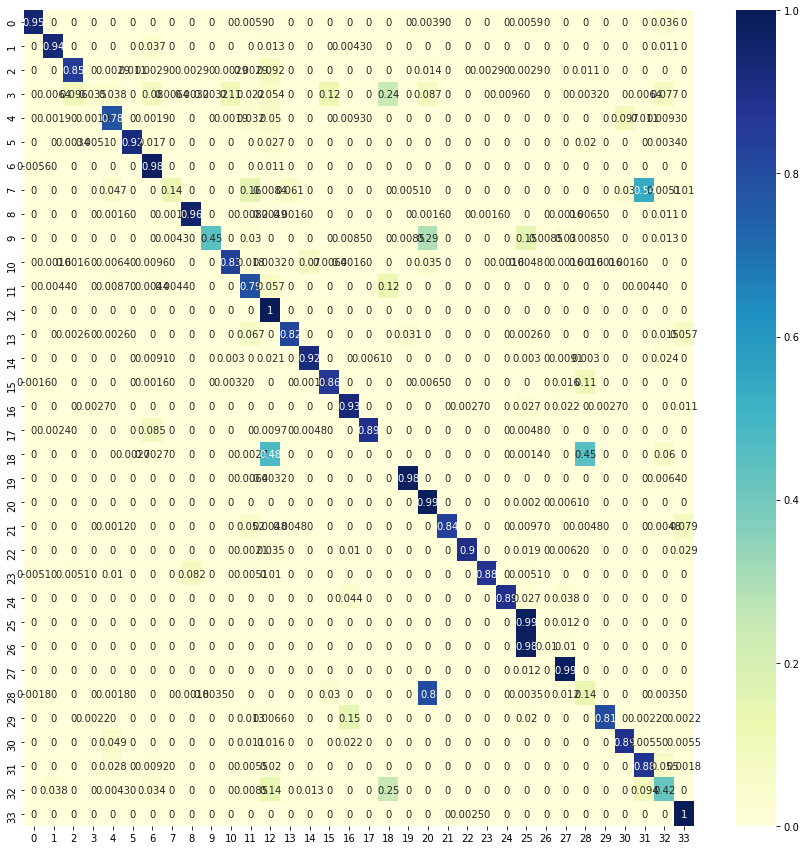

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
sns.heatmap(data=mat1,annot=True,cmap= "YlGnBu")

{'780635': 0,
 '780db4': 1,
 '7804ea': 2,
 '7804f5': 3,
 '780df9': 4,
 '7804bc': 5,
 '780cbc': 6,
 '780fe3': 7,
 '78048f': 8,
 '780063': 9,
 '78087a': 10,
 '780d19': 11,
 '780d8c': 12,
 '7807cb': 13,
 '780830': 14,
 '78027c': 15,
 '780b69': 16,
 '780800': 17,
 '780609': 18,
 '780649': 19,
 '78027b': 20,
 '7805c3': 21,
 '780c2d': 22,
 '78048b': 23,
 '780831': 24,
 '7802b1': 25,
 '780291': 26,
 '780070': 27,
 '780277': 28,
 '7809a3': 29,
 '780dfa': 30,
 '780fb6': 31,
 '780534': 32,
 '78050f': 33}

In [7]:
from Tsne import DecAndPlot


No handles with labels found to put in legend.


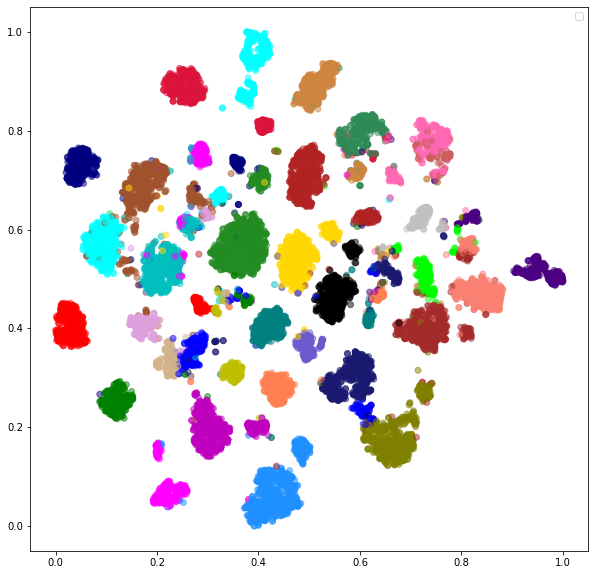

In [8]:

DecAndPlot(X_f,y_f) 
